<a href="https://colab.research.google.com/github/v3xlrm1nOwo1/fungi-diagnostic-chars-comparison-japanese-classification-with-BERT/blob/main/run_model_and_get_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/python_files/fungi-diagnostic-chars-comparison-japanese-classification-with-BERT')

In [3]:
!nvidia-smi

Sat Sep  9 18:42:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install datasets git+https://github.com/thunlp/OpenDelta.git transformers[torch] fugashi unidic_lite

In [5]:
import transformers
import opendelta
import datasets
import numpy as np
import pandas as pd

import data_loader
import config
import engine
import traning
import BERT_japanese_model
import predict

from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from pylab import rcParams

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 13, 4

config.DEVICE

/usr/local/lib/python3.10/dist-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(


device(type='cuda')

In [6]:
data = datasets.load_dataset('Atsushi/fungi_diagnostic_chars_comparison_japanese')

data

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['R3ID', 'No', 'comparison_source', 'comparison_target', 'sentence', 'label', 'common_or_different', 'data_source'],
        num_rows: 306795
    })
})

In [7]:
data['train'][0]

{'R3ID': 'R3-10914',
 'No': 1.0,
 'comparison_source': 'Paranectria longiappendiculata',
 'comparison_target': 'Paranectria affinis',
 'sentence': '本種と異なり重複寄生菌ではなく材生息菌である',
 'label': '生息環境/habitat',
 'common_or_different': 0,
 'data_source': 'https://link.springer.com/article/10.1007/s11557-023-01913-5'}

In [8]:
data.set_format(type='pandas')

In [9]:
df = data['train'][:]
df.head()

,R3ID,No,comparison_source,comparison_target,sentence,label,common_or_different,data_source
0,R3-10914,1.0,Paranectria longiappendiculata,Paranectria affinis,本種と異なり重複寄生菌ではなく材生息菌である,生息環境/habitat,0,https://link.springer.com/article/10.1007/s115...
1,R3-10914,2.0,Paranectria longiappendiculata,Paranectria affinis,本種より子嚢胞子が長い,サイズ/size,0,https://link.springer.com/article/10.1007/s115...
2,R3-10914,3.0,Paranectria longiappendiculata,Paranectria hemileiae,重複寄生菌である,生息環境/habitat,1,https://link.springer.com/article/10.1007/s115...
3,R3-10914,4.0,Paranectria longiappendiculata,Paranectria hemileiae,同じメリオラ目菌類を宿主とする,生息環境/habitat,1,https://link.springer.com/article/10.1007/s115...
4,R3-10914,5.0,Paranectria longiappendiculata,Paranectria hemileiae,子嚢果に毛を有する,表面性状/surface_characteristics,1,https://link.springer.com/article/10.1007/s115...


In [10]:
labels = df['label'].unique()

labels

array(['生息環境/habitat', 'サイズ/size', '表面性状/surface_characteristics',
       '色/color', '形状/shape', '地理的分布/geographical_distribution',
       '形態全般/general_morphology', '有無/presence', '構造/structure',
       '位置/position', '二次代謝産物/secondary_metabolite',
       '分子系統解析/molecular_phylogenetic_analysis', '呈色反応/chemical_reaction',
       '全般/general_characters', '生理学的形質/physiological_characters',
       '耐性・感受性/resistance_and_susceptibility',
       '資化・発酵能/assimilation_and_fermentation', '質感/texture', '数量/amount',
       '発達/development', '栄養摂取様式/nutrition_style',
       '病害・病原性関連/disease_and_pathogenecity', '味・臭い/taste_and_smell',
       '分類/classification', '未分類/unclassified'], dtype=object)

In [11]:
len(labels)

25

In [12]:
label_jp = labels[0].split('/')

label_jp

['生息環境', 'habitat']

In [13]:
LABELS = []
LABELS_JP = []
for label in labels:
    print(label.split('/'))
    LABELS.append(label.split('/')[0])
print(LABELS)
print(len(LABELS))

['生息環境', 'habitat']
['サイズ', 'size']
['表面性状', 'surface_characteristics']
['色', 'color']
['形状', 'shape']
['地理的分布', 'geographical_distribution']
['形態全般', 'general_morphology']
['有無', 'presence']
['構造', 'structure']
['位置', 'position']
['二次代謝産物', 'secondary_metabolite']
['分子系統解析', 'molecular_phylogenetic_analysis']
['呈色反応', 'chemical_reaction']
['全般', 'general_characters']
['生理学的形質', 'physiological_characters']
['耐性・感受性', 'resistance_and_susceptibility']
['資化・発酵能', 'assimilation_and_fermentation']
['質感', 'texture']
['数量', 'amount']
['発達', 'development']
['栄養摂取様式', 'nutrition_style']
['病害・病原性関連', 'disease_and_pathogenecity']
['味・臭い', 'taste_and_smell']
['分類', 'classification']
['未分類', 'unclassified']
['生息環境', 'サイズ', '表面性状', '色', '形状', '地理的分布', '形態全般', '有無', '構造', '位置', '二次代謝産物', '分子系統解析', '呈色反応', '全般', '生理学的形質', '耐性・感受性', '資化・発酵能', '質感', '数量', '発達', '栄養摂取様式', '病害・病原性関連', '味・臭い', '分類', '未分類']
25


In [14]:
df['label_text'] = df['label'].apply(func = (lambda label: label.split('/')[0] ))

In [15]:
df.head()

,R3ID,No,comparison_source,comparison_target,sentence,label,common_or_different,data_source,label_text
0,R3-10914,1.0,Paranectria longiappendiculata,Paranectria affinis,本種と異なり重複寄生菌ではなく材生息菌である,生息環境/habitat,0,https://link.springer.com/article/10.1007/s115...,生息環境
1,R3-10914,2.0,Paranectria longiappendiculata,Paranectria affinis,本種より子嚢胞子が長い,サイズ/size,0,https://link.springer.com/article/10.1007/s115...,サイズ
2,R3-10914,3.0,Paranectria longiappendiculata,Paranectria hemileiae,重複寄生菌である,生息環境/habitat,1,https://link.springer.com/article/10.1007/s115...,生息環境
3,R3-10914,4.0,Paranectria longiappendiculata,Paranectria hemileiae,同じメリオラ目菌類を宿主とする,生息環境/habitat,1,https://link.springer.com/article/10.1007/s115...,生息環境
4,R3-10914,5.0,Paranectria longiappendiculata,Paranectria hemileiae,子嚢果に毛を有する,表面性状/surface_characteristics,1,https://link.springer.com/article/10.1007/s115...,表面性状


In [22]:
df.shape

(306795, 3)

In [16]:
df = df[['sentence', 'label_text']]

df.head()

,sentence,label_text
0,本種と異なり重複寄生菌ではなく材生息菌である,生息環境
1,本種より子嚢胞子が長い,サイズ
2,重複寄生菌である,生息環境
3,同じメリオラ目菌類を宿主とする,生息環境
4,子嚢果に毛を有する,表面性状


In [17]:
def convert_label_to_number(label):
    for label_num, label_txt in enumerate(LABELS):
        if label == label_txt:
            return label_num

In [18]:
df['label_number'] = df['label_text'].apply(func = convert_label_to_number)

df.head()

,sentence,label_text,label_number
0,本種と異なり重複寄生菌ではなく材生息菌である,生息環境,0
1,本種より子嚢胞子が長い,サイズ,1
2,重複寄生菌である,生息環境,0
3,同じメリオラ目菌類を宿主とする,生息環境,0
4,子嚢果に毛を有する,表面性状,2


In [19]:
df['label_number'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24])

In [20]:
# ['label'].str.decode('utf-8')

Text(0.5, 0, 'labels')

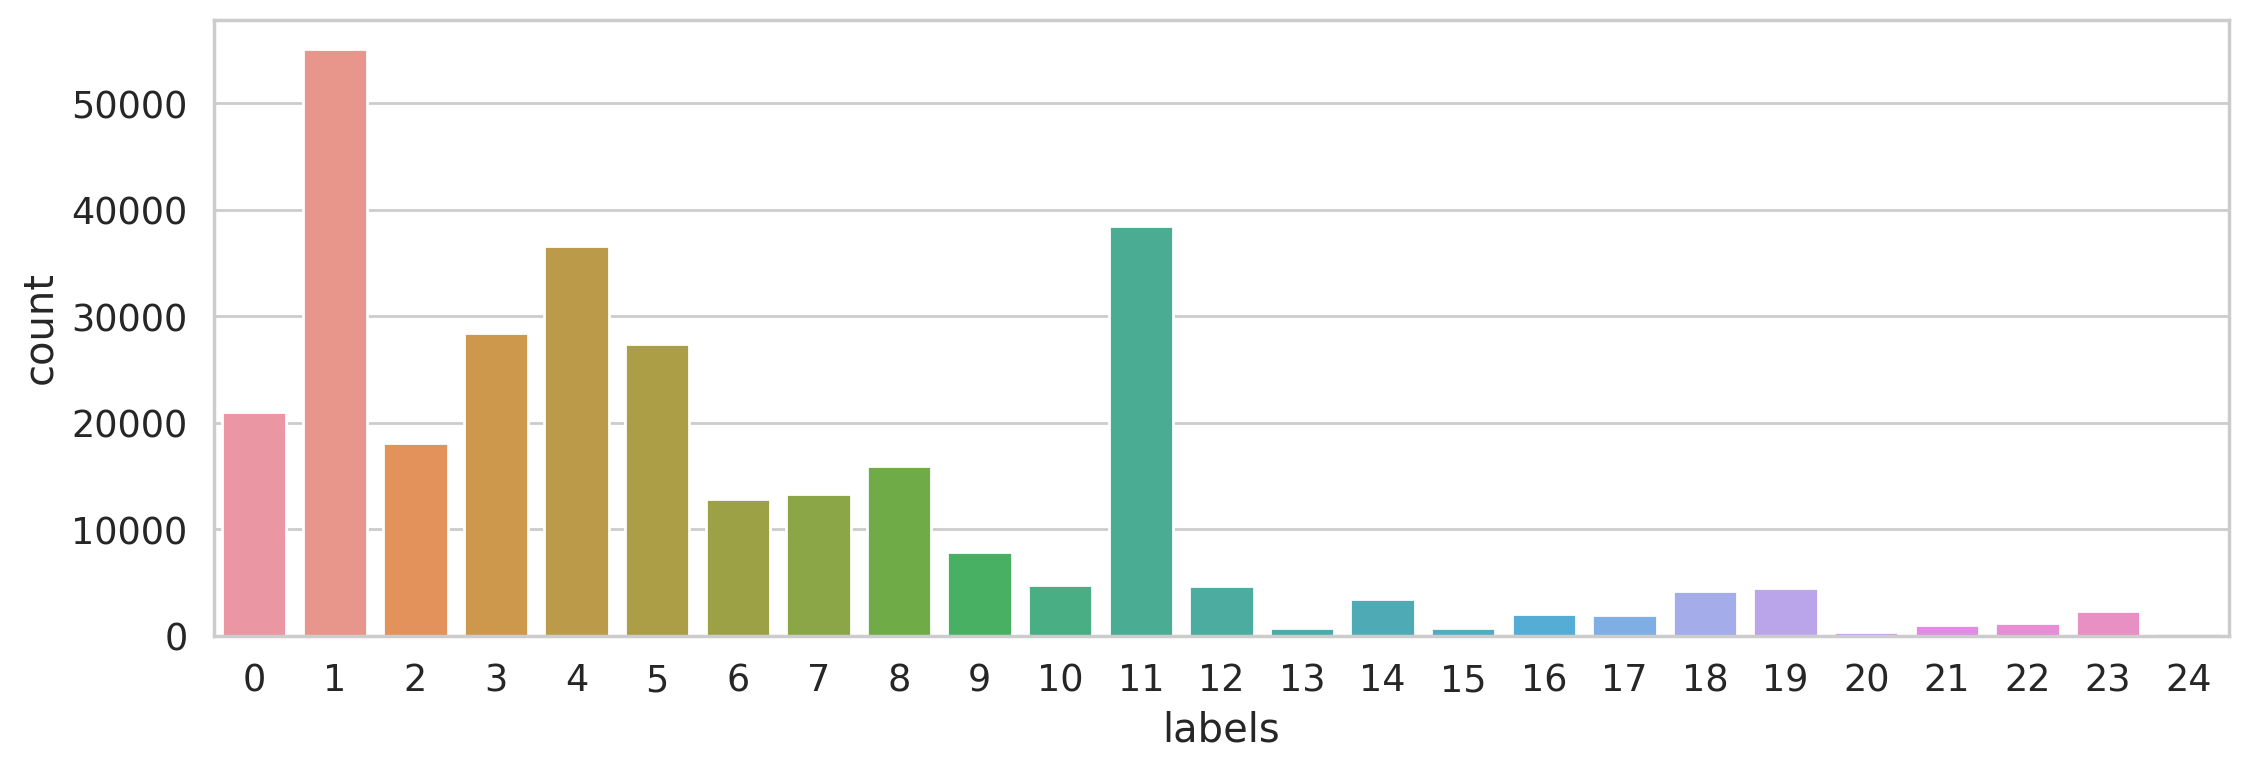

In [21]:
ax = sns.countplot(x=df.label_number)
plt.xlabel('labels')
# ax.set_xticklabels(LABELS)

In [37]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=config.RANDOM_SEED)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=config.RANDOM_SEED)

train_df.shape, val_df.shape, test_df.shape

((276115, 3), (15340, 3), (15340, 3))

In [24]:
token_lens = []

for txt in df.sentence:
  tokens = config.TOKENIZER.encode(txt)
  token_lens.append(len(tokens))

<ipython-input-25-1ab8bd8e5df3>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens, hist=True)


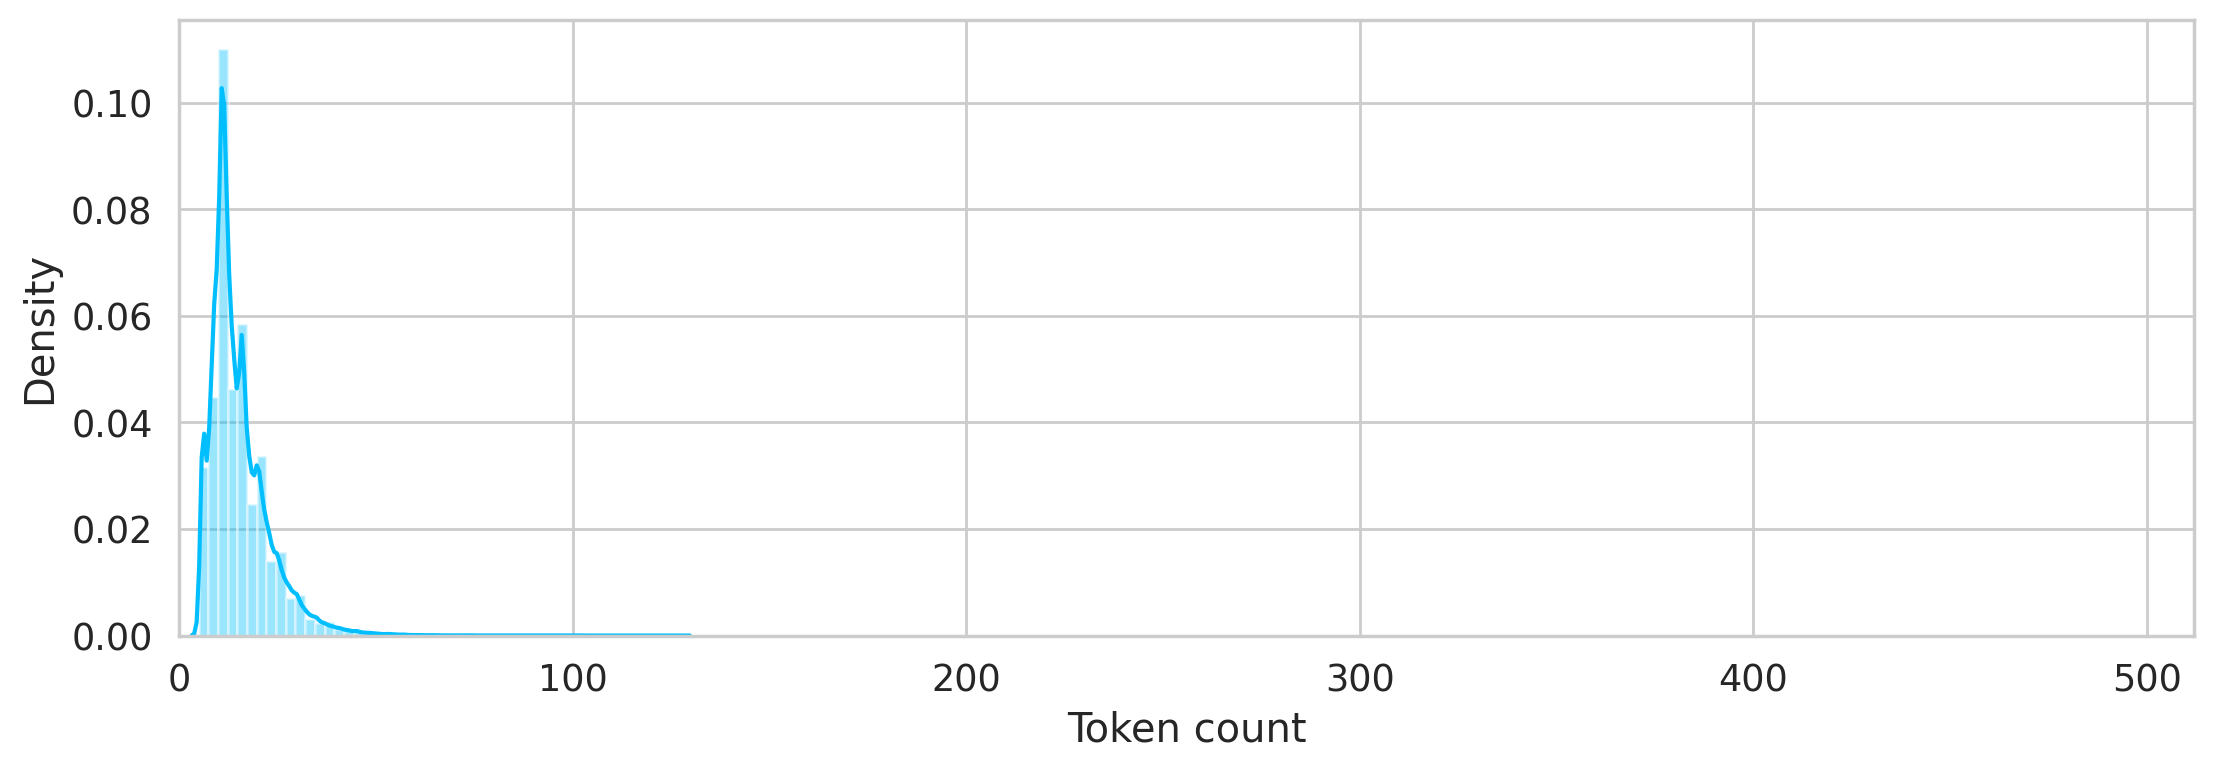

In [25]:
sns.distplot(token_lens, hist=True)
plt.xlim([0, 512]);
plt.xlabel('Token count');

In [ ]:
train_data_loader = data_loader.create_data_loader(df=train_df, tokenizer=config.TOKENIZER, max_len=config.MAX_LEN, batch_size=config.TRAIN_BATCH_SIZE, shuffle=True)
val_data_loader = data_loader.create_data_loader(df=val_df, tokenizer=config.TOKENIZER, max_len=config.MAX_LEN, batch_size=config.VALID_BATCH_SIZE, shuffle=False)
test_data_loader = data_loader.create_data_loader(df=test_df, tokenizer=config.TOKENIZER, max_len=config.MAX_LEN, batch_size=config.TEST_BATCH_SIZE, include_row_text=True, shuffle=False)

In [27]:
data = next(iter(test_data_loader))
data.keys()

dict_keys(['input_ids', 'attention_mask', 'labels', 'sentence_text'])

In [28]:
model = BERT_japanese_model.SentimentClassifier(config.NUMBER_OF_CLASSES)
model = model.to(config.DEVICE)

In [29]:
delta_model = opendelta.AdapterModel(model)
delta_model.freeze_module(exclude=['deltas', 'classifier'])
delta_model.log()

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


root
├── model (BertModel)
│   ├── embeddings (BertEmbeddings)
│   │   ├── word_embeddings (Embedding) weight:[32768, 768]
│   │   ├── position_embeddings (Embedding) weight:[512, 768]
│   │   ├── token_type_embeddings (Embedding) weight:[2, 768]
│   │   └── LayerNorm (LayerNorm) weight:[768] bias:[768]
│   ├── encoder (BertEncoder)
│   │   └── layer (ModuleList)
│   │       └── 0-11(BertLayer)
│   │           ├── attention (BertAttention)
│   │           │   ├── self (BertSelfAttention)
│   │           │   │   └── query,key,value(Linear) weight:[768, 768] bias:[768]
│   │           │   └── output (BertSelfOutput)
│   │           │       ├── dense (Linear) weight:[768, 768] bias:[768]
│   │           │       │   └── adapter (AdapterLayer)
│   │           │       │       └── modulelist (Sequential)
│   │           │       │           ├── down_proj (Linear) weight:[24, 768] bias:[24]
│   │           │       │           └── up_proj (Linear) weight:[768, 24] bias:[768]
│   │           │       └── LayerNorm (LayerNorm) weight:[768] bias:[768]
│   │           ├── intermediate (BertIntermediate)
│   │           │   └── dense (Linear) weight:[3072, 768] bias:[3072]
│   │           └── output (BertOutput)
│   │               ├── dense (Linear) weight:[768, 3072] bias:[768]
│   │               │   └── adapter (AdapterLayer)
│   │               │       └── modulelist (Sequential)
│   │               │           ├── down_proj (Linear) weight:[24, 768] bias:[24]
│   │               │           └── up_proj (Linear) weight:[768, 24] bias:[768]
│   │               └── LayerNorm (LayerNorm) weight:[768] bias:[768]
│   └── pooler (BertPooler)
│       └── dense (Linear) weight:[768, 768] bias:[768]
└── out (Linear) weight:[25, 768] bias:[25]

[INFO|(OpenDelta)basemodel:698]2023-09-09 18:45:22,843 >> Trainable Ratio: 903744/112130137=0.805978%
[INFO|(OpenDelta)basemodel:700]2023-09-09 18:45:22,845 >> Delta Parameter Ratio: 903744/112130137=0.805978%
[INFO|(OpenDelta)basemodel:702]2023-09-09 18:45:22,848 >> Static Memory 0.43 GB, Max Memory 0.44 GB


In [ ]:
optimizer = transformers.AdamW(model.parameters(), lr=config.LEARN_RATE, correct_bias=False)

In [ ]:
best_accuracy, history = traning.train(model=model, delta_model=delta_model, train_data_loader=train_data_loader, optimizer=optimizer, val_data_loader=val_data_loader, n_train_examples=len(train_df), n_val_examples=len(val_df))

In [ ]:
loss, accuracy, y_sentence_texts, y_pred, y_pred_probs, y_test = predict.prediction(test_data_loader, model, n_examples=len(test_df))

In [ ]:
loss, accuracy

In [35]:
def show_pred(idx):
    sentence_text = y_sentence_texts[idx]
    true_sentiment = y_test[idx]
    pred_df = pd.DataFrame({
    'class_names': LABELS,
    'values': y_pred_probs[idx]
    })

    print(sentence_text)
    print()
    print(f'True label: {LABELS[true_sentiment]}')


    sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
    plt.ylabel('labels')
    plt.xlabel('probability')
    plt.xlim([0, 1]);

In [ ]:
show_pred(2)